# Complementary Filter for Slow 9DOF IMU tilting

In [1]:
import time
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import filtfilt, butter
from math import *

#for COM port reading
import serial
import serial.tools.list_ports

#interactive magic
%matplotlib notebook


In [2]:
#Function to capture data through the COM port. 
#If you wanted to use this for live plotting you would need to set up a threaded process and have a data buffer

def comCapture(port, capturetime):

    ser = serial.Serial(port, 115200, timeout=1)
    #sleeping to wait for artemis openlog to stop complaining about no SD card
    time.sleep(2)
    
    start_time = time.time()
    timepoints = []
    accX_data, accY_data, accZ_data = [], [], []
    gyrX_data, gyrY_data, gyrZ_data = [], [], []
    magX_data, magY_data, magZ_data = [], [], []

    # flush any junk left in the serial buffer
    ser.flushInput()
    
    run = True  
    # collect the data and plot a moving frame
    while run:
        
        #line by line COM port read
        ser.reset_input_buffer()
        data = ser.readline()
        data = data.rstrip()
        data = data.decode('utf-8')
        #data is list of instantaneous sensor outputs
        data = data.split(',')
        
        
        try:
            # store the entire dataset for later
            accX_data.append(float(data[2]))
            accY_data.append(float(data[3]))
            accZ_data.append(float(data[4]))

            gyrX_data.append(float(data[5]))
            gyrY_data.append(float(data[6]))
            gyrZ_data.append(float(data[7]))

            magX_data.append(float(data[8]))
            magY_data.append(float(data[9]))
            magZ_data.append(float(data[10]))

            timepoints.append(time.time()-start_time)
            current_time = timepoints[-1]

            if timepoints[-1] > capturetime: run=False

        except: pass
        
    tlen=len(timepoints)-1
        
    acc = np.column_stack((accX_data[1:tlen], accY_data[1:tlen], accZ_data[1:tlen]))
    gyr = np.column_stack((gyrX_data[1:tlen], gyrY_data[1:tlen], gyrZ_data[1:tlen]))
    mag = np.column_stack((magX_data[1:tlen], magY_data[1:tlen], magZ_data[1:tlen]))
    timepoints = timepoints[1:tlen]

    ser.close()
    
    return acc, gyr, mag, timepoints

In [3]:
#handy plotting functions

def plot9DOF(time, acc, gyr, mag):
        
    figacc, ((axac1, axgy1, axma1), (axac2, axgy2, axma2), (axac3, axgy3, axma3)) = plt.subplots(3,3)
    figacc.set_size_inches(11,8)
    
    accX, = axac1.plot(time, acc[:,0],linestyle='-', color='orange')
    accY, = axac2.plot(time, acc[:,1],linestyle='-', color='orange')
    accZ, = axac3.plot(time, acc[:,2],linestyle='-', color='orange')

    gyrX, = axgy1.plot(time, gyr[:,0],linestyle='-', color='green')
    gyrY, = axgy2.plot(time, gyr[:,1],linestyle='-', color='green')
    gyrZ, = axgy3.plot(time, gyr[:,2],linestyle='-', color='green')
    
    magX, = axma1.plot(time, mag[:,0],linestyle='-', color='blue')
    magY, = axma2.plot(time, mag[:,1],linestyle='-', color='blue')
    magZ, = axma3.plot(time, mag[:,2],linestyle='-', color='blue')


    axac1.title.set_text('Accelerometer Output')
    axac1.set(xlabel="", ylabel="X (mg)")
    axac2.set(xlabel="", ylabel="Y (mg)")
    axac3.set(xlabel="Time(s)", ylabel="Z (mg)")

    axgy1.title.set_text('Gyroscope Output')
    axgy1.set(xlabel="", ylabel="X (dps)")
    axgy2.set(xlabel="", ylabel="Y (dps)")
    axgy3.set(xlabel="Time(s)", ylabel="Z (dps)")
    
    axma1.title.set_text('Magnetometer Output')
    axma1.set(xlabel="", ylabel="X (uT)")
    axma2.set(xlabel="", ylabel="Y (uT)")
    axma3.set(xlabel="Time(s)", ylabel="Z (uT)")

    figacc.tight_layout(pad=1.5)
    figacc.align_labels()
    
def plotmag(mag):
    axlm=90
    fig3D=plt.figure()
    ax3D = fig3D.add_subplot(111, projection='3d')
    fig3D.set_size_inches(8,8)
    ax3D.scatter3D(mag[:,0],mag[:,1],mag[:,2])
    
    ax3D.set_xlabel('Mag X (uT)')
    ax3D.set_ylabel('Mag Y (uT)')
    ax3D.set_zlabel('Mag Z (uT)')
    ax3D.set_xlim(-axlm, axlm)
    ax3D.set_ylim(-axlm, axlm)
    ax3D.set_zlim(-axlm, axlm)

    plt.show()

    fig2D=plt.figure()
    ax2D = fig2D.add_subplot()
    ax2D.title.set_text('Raw Magnetometer Data')
    plt.scatter(mag[:,0],mag[:,1], label='Mag x vs Mag y')
    plt.scatter(mag[:,1],mag[:,2], label='Mag y vs Mag z')
    plt.scatter(mag[:,0],mag[:,2], label='Mag x vs Mag z')
    ax2D.set_xlabel('Mag axis i (uT)')
    ax2D.set_ylabel('Mag axis j (uT)')
    ax2D.set_xlim(-axlm, axlm)
    ax2D.set_ylim(-axlm, axlm)
    ax2D.legend()
    
def plotmagcal(magraw, magcal):
    axlm=90
    fig3D=plt.figure()
    ax3D = fig3D.add_subplot(111, projection='3d')
    fig3D.set_size_inches(8,8)
    ax3D.title.set_text('Magnetometer Calibration')
    ax3D.scatter3D(magraw[:,0],magraw[:,1],magraw[:,2], color="blue", alpha=0.1, label='Uncalibrated')
    ax3D.scatter3D(magcal[:,0],magcal[:,1],magcal[:,2], color="red", alpha=0.1, label='Calibrated')
    ax3D.legend()
    ax3D.set_xlabel('Mag X (uT)')
    ax3D.set_ylabel('Mag Y (uT)')
    ax3D.set_zlabel('Mag Z (uT)')
    ax3D.set_xlim(-axlm, axlm)
    ax3D.set_ylim(-axlm, axlm)
    ax3D.set_zlim(-axlm, axlm)

def angleplot(timepoints, roll, pitch, yaw):
    fig=plt.figure()
    ax = fig.add_subplot()
    ax.title.set_text('Euler Angles')
    plt.plot(timepoints, roll, label=r'Roll ($\phi$)')
    plt.plot(timepoints, pitch, label=r'Pitch ($\theta$)')
    plt.plot(timepoints, yaw, label=r'Yaw ($\psi$)')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Angle (degrees)')
    ax.legend()
    

# Data Reading

I used an Artemis Openlog. I capture the data through a serial USB COM port. With some small modifications you could read the accelerometer, gyroscope, and magnetometer data into numpy arrays from a file. The data is assumed to have the following structure with no header:

RTC date, RTC time, IMU accelerometer readings (mg), IMU gyro readings (dps), IMU magnetometer readings (uT), IMU temperature (C), the logging rate (Hz).

Speed / Baud Rate: 115200

In [4]:
#find serial port of device for real-time device reading
ports = serial.tools.list_ports.comports()
[port.device for port in ports]
#Manually set it artemis COM port
port=ports[0].device
port

'COM3'

# Accelerometer and Gyroscope Calibration

<IPython.core.display.Javascript object>


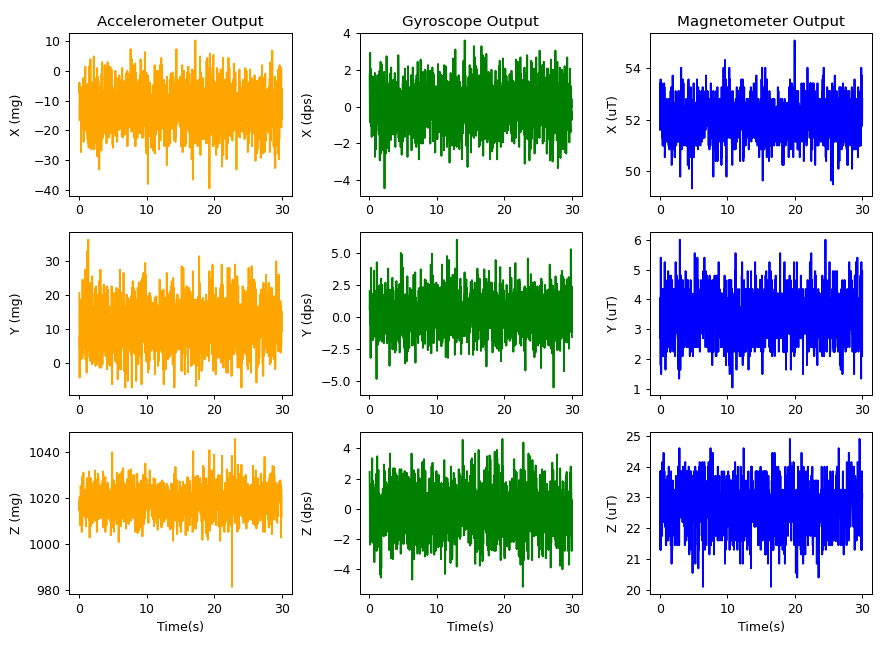

<IPython.core.display.Javascript object>


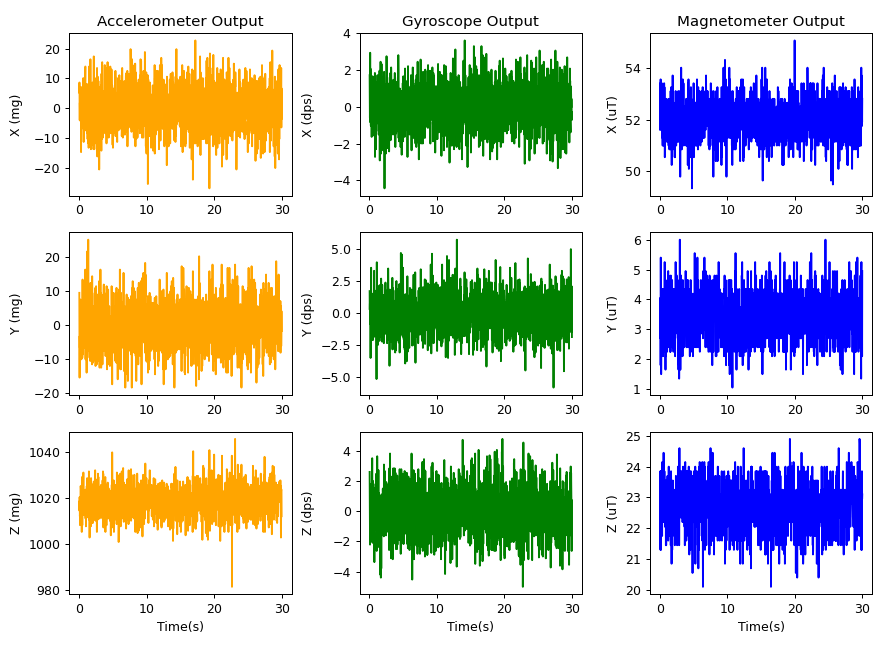

In [5]:
#gyro and accelerometer bias zeroing (capture data with device at rest, z down toward gravity)

#capture and plot raw data
acc, gyr, mag, timepoints = comCapture(port, 30)
plot9DOF(timepoints, acc, gyr, mag)

#calculate accelerometer offset
accX_zero=np.mean(acc[:,0])
accY_zero=np.mean(acc[:,1])

acc[:,0]=acc[:,0]-accX_zero
acc[:,1]=acc[:,1]-accY_zero

#find magnitude of gravity (note used since all trigonometric functions are ratios)
g=sqrt(np.mean(acc[:,0])**2+np.mean(acc[:,1])**2+np.mean(acc[:,2])**2)

#find average time difference between data capture points (capture frequency varies a little)
dt=np.mean(np.diff(timepoints))

#calibrate and apply gyro offset
gyrX_zero=np.mean(gyr[:,0])
gyrY_zero=np.mean(gyr[:,1])
gyrZ_zero=np.mean(gyr[:,2])

gyr[:,0]=gyr[:,0]-gyrX_zero
gyr[:,1]=gyr[:,1]-gyrY_zero
gyr[:,2]=gyr[:,2]-gyrZ_zero

#plot calibrated data (magnetometer has yet to be calibrated)
plot9DOF(timepoints, acc, gyr, mag)

# Magnetometer Calibration

<IPython.core.display.Javascript object>


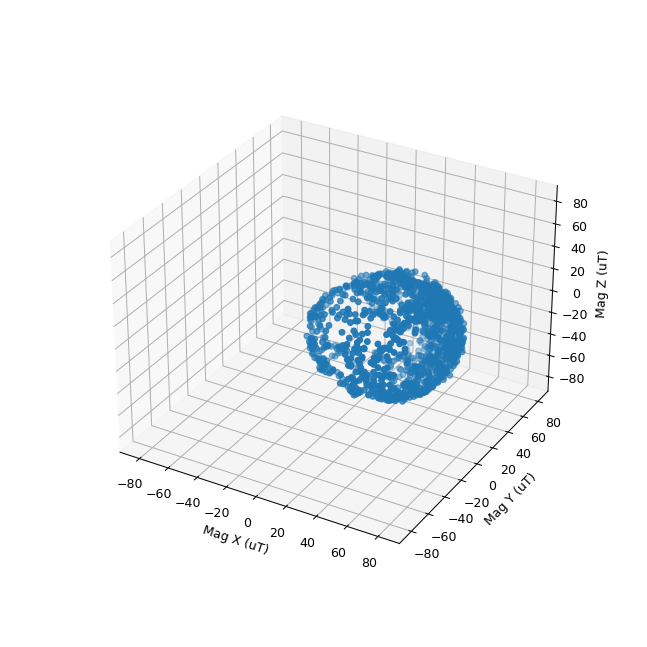

<IPython.core.display.Javascript object>


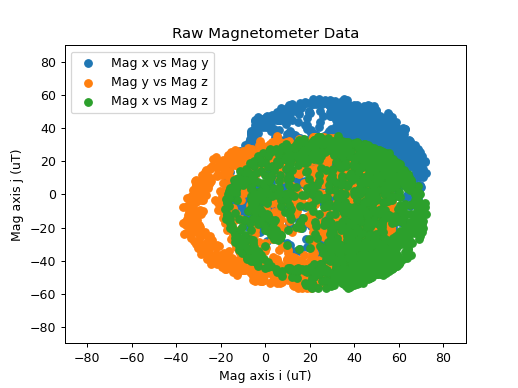

<IPython.core.display.Javascript object>


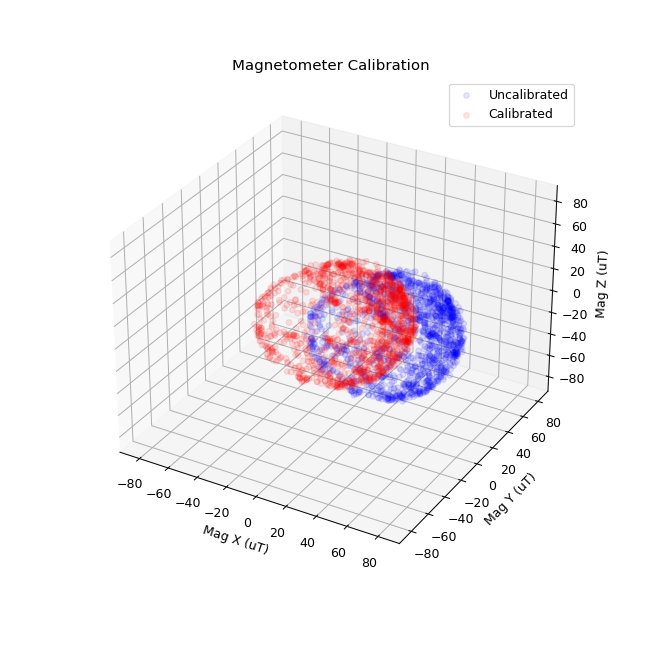

In [6]:
#mag hard iron calibration (capture data with device rotating to see all directions)
acc, gyr, mag, timepoints = comCapture(port, 30)
plotmag(mag)

lowpass=0.05
magf = filtfilt(*butter(2, lowpass, btype='low'), mag, axis=0 )
mag_cal=np.zeros(np.shape(mag))

#hard iron offset
magX_zero=(np.max(magf[:,0])+np.min(magf[:,0]))*0.5
magY_zero=(np.max(magf[:,1])+np.min(magf[:,1]))*0.5
magZ_zero=(np.max(magf[:,2])+np.min(magf[:,2]))*0.5

mag_cal[:,0]=mag[:,0]-magX_zero
mag_cal[:,1]=mag[:,1]-magY_zero
mag_cal[:,2]=mag[:,2]-magZ_zero

#basic soft iron "sphering" 
dmagX=(np.max(magf[:,0])-np.min(magf[:,0]))*0.5
dmagY=(np.max(magf[:,1])-np.min(magf[:,1]))*0.5
dmagZ=(np.max(magf[:,2])-np.min(magf[:,2]))*0.5
dmag_av = (dmagX + dmagY + dmagZ) / 3

magX_scale = dmag_av / dmagX
magY_scale = dmag_av / dmagY
magZ_scale = dmag_av / dmagZ

mag_cal[:,0]=mag_cal[:,0]*magX_scale
mag_cal[:,1]=mag_cal[:,1]*magY_scale
mag_cal[:,2]=mag_cal[:,2]*magZ_scale

#mag zering and "sphering" calibrations for later use
mag_zero=[magX_zero, magY_zero, magZ_zero]
mag_scale=[magX_scale, magY_scale, magZ_scale]

#magnetic field strength magnitude
m=sqrt(np.mean(magf[:,0])**2+np.mean(magf[:,1])**2+np.mean(magf[:,2])**2)

plotmagcal(mag, mag_cal)

# Real Data Collection

<IPython.core.display.Javascript object>


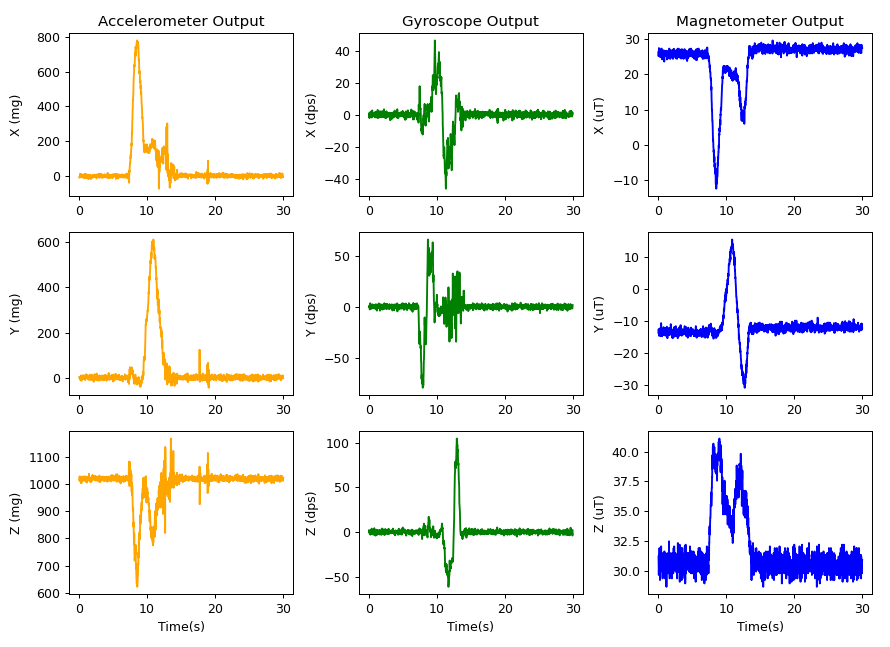

In [9]:
acc, gyr, mag, timepoints = comCapture(port, 30)

mag_c=np.zeros(np.shape(mag))

#calibrations from prior calibration data sets above
acc[:,0]=acc[:,0]-accX_zero
acc[:,1]=acc[:,1]-accY_zero

gyr[:,0]=gyr[:,0]-gyrX_zero
gyr[:,1]=gyr[:,1]-gyrY_zero
gyr[:,2]=gyr[:,2]-gyrZ_zero

mag[:,0]=(mag[:,0]-magX_zero)*magX_scale
mag[:,1]=(mag[:,1]-magY_zero)*magY_scale
mag[:,2]=(mag[:,2]-magZ_zero)*magZ_scale

plot9DOF(timepoints, acc, gyr, mag)

# The Complementary Filter

<IPython.core.display.Javascript object>


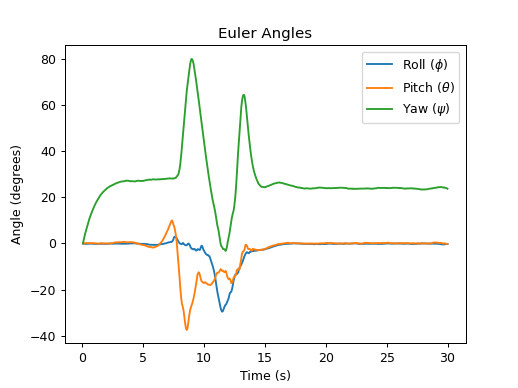

In [11]:
roll, pitch, yaw = np.zeros(len(timepoints)), np.zeros(len(timepoints)), np.zeros(len(timepoints))
rollgyr, pitchgyr, yawgyr = np.zeros(len(timepoints)), np.zeros(len(timepoints)), np.zeros(len(timepoints))
rollacc, pitchacc, yawacc = np.zeros(len(timepoints)), np.zeros(len(timepoints)), np.zeros(len(timepoints))

lowpass=0.05
highpass=0.01

acc = filtfilt(*butter(3, lowpass, btype='low'), acc, axis=0 )
gyr = filtfilt(*butter(3, highpass, btype='high'), gyr, axis=0 )
mag = filtfilt(*butter(2, lowpass, btype='low'), mag, axis=0 )

#set roll, pitch, and yaw initializations from the accelerometer/magnetometer
rollacc[0]=atan2(-acc[0,1], acc[0,2])
pitchacc[0]=atan2(-acc[0,0], sqrt(((acc[0,1])**2+(acc[0,2])**2)))

m_num=-mag[0,1]*cos(roll[0])+mag[0,2]*sin(roll[0])
m_dom=mag[0,0]*cos(pitch[0])+mag[0,1]*sin(roll[0])*sin(pitch[0])+mag[0,2]*cos(roll[0])*sin(pitch[0])

yawacc[0]=atan2(m_num,m_dom)

#complementary filter
k=0.98
for i in range(1,len(timepoints)):
    
    rollacc[i]=atan2(-acc[i,1], acc[i,2])
    pitchacc[i]=atan2(-acc[i,0], sqrt(((acc[i,1])**2+(acc[i,2])**2)))
    
    m_num=-mag[i,1]*cos(roll[i])+mag[i,2]*sin(roll[i])
    m_dom=mag[i,0]*cos(pitch[i])+mag[i,1]*sin(roll[i])*sin(pitch[i])+mag[i,2]*cos(roll[i])*sin(pitch[i])
    
    yawacc[i]=atan2(m_num,m_dom)
    
    yawgyr[i]=yaw[i-1]+dt*(pi/180)*(sin(roll[i-1])*gyr[i,1]+cos(roll[i-1])*gyr[i,2])/cos(pitch[i-1])
    pitchgyr[i]=pitch[i-1]+dt*(pi/180)*(cos(roll[i-1])*cos(pitch[i-1])*gyr[i,1]-sin(roll[i-1])*cos(pitch[i-1])*gyr[i,2])/cos(pitch[i-1])
    rollgyr[i]=roll[i-1]+dt*(pi/180)*(cos(pitch[i-1])*gyr[i,0]+sin(roll[i-1])*sin(pitch[i-1])*gyr[i,1]+cos(roll[i-1])*sin(pitch[i-1])*gyr[i,2])/cos(pitch[i-1])
    
    roll[i]=k*rollgyr[i]+(1-k)*rollacc[i]
    pitch[i]=k*pitchgyr[i]+(1-k)*pitchacc[i]
    yaw[i]=k*yawgyr[i]+(1-k)*yawacc[i]
    
angleplot(timepoints, roll*180/pi, pitch*180/pi, yaw*180/pi)